In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import io

import pyspark.sql.functions as F
import pyspark

from pyspark.sql import SparkSession, Window
from pyspark.conf import SparkConf
# from pyspark.context import SparkContext
from pyspark.sql.types import StringType, ArrayType, StructField, StructType, FloatType, DoubleType, IntegerType

from concurrent.futures import ThreadPoolExecutor

In [2]:
# `sparksession is none: typeerror: 'javapackage' object is not 
# callable` can be raised if the pyspark version being used is 4.0.0
# which is not compatible to a python 3.11.8 version
spark = SparkSession.builder.appName("app").getOrCreate()
    # .config("spark.driver.memory", "14g")\
    # .config("spark.sql.execution.arrow.maxRecordsPerBatch", "100")\
    # .getOrCreate()

In [ ]:
# BRONZE_FOLDER_NAME = "sgppipelinesa-bronze"
# URL = "abfss://{FOLDER_NAME}@sgppipelinesa.dfs.core.windows.net/"
# BRONZE_DATA_PATH = URL.format(FOLDER_NAME=BRONZE_FOLDER_NAME)
# BRONZE_DATA_PATH
# folder_infos = dbutils.fs.ls(BRONZE_DATA_PATH)
BRONZE_FOLDER_NAME = "bronze/"
DATA_PATH = "../include/data/"
BRONZE_DATA_PATH = os.path.join(DATA_PATH, BRONZE_FOLDER_NAME)

In [4]:
# sample_folder = folder_infos[-1].path
# sample_folder

In [5]:
# sample_folder.strip('/').split('/')[-1]

In [6]:
# type(folder_infos[-1])

In [7]:
# dbutils.fs.ls(folder_infos[-1].path)

In [8]:
file_infos = os.listdir(BRONZE_DATA_PATH)
file_infos

['1028-20100710-hne',
 '1337ad-20170321-ajg',
 '1337ad-20170321-tkg',
 '1snoke-20120412-hge',
 '23yipikaye-20100807-ujm',
 'Aaron-20080318-kdl',
 'Anniepoo-20140308-bft',
 'Anniepoo-20140308-cqj',
 'Anniepoo-20140308-fcp',
 'Anniepoo-20140308-hns',
 'Anniepoo-20140308-nky',
 'Coren-20141121-pxp']

In [9]:
# labels_df = spark.read.format('text')\
#     .option("lineSep", "\n")\
#     .load(os.path.join(BRONZE_DATA_PATH, "1337ad-20170321-ajg", "etc", "README"))
# labels_df.show()

In [10]:
labels_df = spark.read.format("text")\
    .option("lineSep", "\n")\
    .load([os.path.join(BRONZE_DATA_PATH, file_info, "etc", "README") for file_info in file_infos])
# labels_df = spark.read.format("text")\
#     .option("wholeText", "true")\
#     .load([os.path.join(BRONZE_DATA_PATH, file_info, "etc", "README") for file_info in file_infos])
labels_df.show()

+--------------------+
|               value|
+--------------------+
|    User Name:1337ad|
|                    |
|Speaker Character...|
|                    |
|      Gender: Female|
|    Age Range: Adult|
|        Language: EN|
|Pronunciation dia...|
|                    |
|Recording Informa...|
|                    |
|Microphone make: n/a|
|Microphone type: ...|
|Audio card make: ...|
|Audio card type: ...|
|Audio Recording S...|
|                O/S:|
|                    |
|          File Info:|
|                    |
+--------------------+
only showing top 20 rows



In [11]:
# labels_df.count()

In [12]:
# labels_df.withColumn("filePath", F.input_file_name()).show()

In [13]:
# labels_df.withColumn("filePath", F.input_file_name()).where(
#     F.lower(F.col("value")).contains("gender")
# ).collect()

In [14]:
labels_df = labels_df.withColumn("filePath", F.input_file_name())
labels_df.show()

+--------------------+--------------------+
|               value|            filePath|
+--------------------+--------------------+
|    User Name:1337ad|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Speaker Character...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|      Gender: Female|file:///c:/Users/...|
|    Age Range: Adult|file:///c:/Users/...|
|        Language: EN|file:///c:/Users/...|
|Pronunciation dia...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Recording Informa...|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|Microphone make: n/a|file:///c:/Users/...|
|Microphone type: ...|file:///c:/Users/...|
|Audio card make: ...|file:///c:/Users/...|
|Audio card type: ...|file:///c:/Users/...|
|Audio Recording S...|file:///c:/Users/...|
|                O/S:|file:///c:/Users/...|
|                    |file:///c:/Users/...|
|          File Info:|file:///c:/Users/...|
|                    |file:///c:

In [15]:
labels_df = labels_df.where(F.lower(F.col("value")).contains("gender"))
# labels_df.show()

# Clean value columns

In [16]:
labels_df = labels_df.withColumn(
    "value", 
    # extract only the gender of the subject in meta data
    F.regexp_replace(
        F.lower(F.col("value")), 
        r"(gender)|[:;\[\]\t\n\s]+", 
        ""
    )
)
# labels_df.show()

In [17]:
labels_df = labels_df.withColumn(
    "value",
    # sometimes the gender may be in a different language
    # e.g. the 'male' in german may have the string start
    # with 'mä' so we should return male if this is the case
    # and vice versa for females translated to a different
    # language 
    F.when(
        F.col("value").startswith("ma") | F.col("value").startswith("mä"),
        "male"
    ).when(
        F.col("value").startswith("fem") | F.col("value").startswith("wei"),
        "female"
    ).otherwise(
        "unknown"
    )
)
# labels_df.show()

# clean filePath column

In [18]:
# labels_df.withColumn(
#     "subjectId",
#     F.element_at(
#         # splits the filepath from 'file:///c:/Users/LARRY/Documents/Scripts/.../bronze/1337ad-20170321-ajg/etc/README
#         # to array of the directory tree of the files path e.g. 
#         # ['file:', ..., 'Scripts', ..., 'bronze', '<subject id>, 'etc', 'readme']
#         # so in order to extract subject id or the file name we have to 
#         # get the 3rd to the last element
#         F.split(
#             F.col("filepath"),
#             r"\/"
#         ),
#         -3
#     )
# ).collect()

In [19]:
labels_df = labels_df.withColumn(
    "subjectId",
    F.element_at(
        # splits the filepath from 'file:///c:/Users/LARRY/Documents/Scripts/.../bronze/1337ad-20170321-ajg/etc/README
        # to array of the directory tree of the files path e.g. 
        # ['file:', ..., 'Scripts', ..., 'bronze', '<subject id>, 'etc', 'readme']
        # so in order to extract subject id or the file name we have to 
        # get the 3rd to the last element
        F.split(
            F.col("filepath"),
            r"\/"
        ),
        -3
    )
)
# labels_df.show()

In [20]:
labels_df.persist()

DataFrame[value: string, filePath: string, subjectId: string]

In [21]:
male_labels_df = labels_df.where(F.col("value") == "male")
# male_labels_df.show()

In [22]:
female_labels_df = labels_df.where(F.col("value") == "female")
# female_labels_df.show()

In [23]:
male_labels_df.persist()
female_labels_df.persist()

DataFrame[value: string, filePath: string, subjectId: string]

In [24]:
train_male_labels_df, val_male_labels_df, test_male_labels_df = male_labels_df.randomSplit(weights=[0.7, 0.15, 0.15], seed=0)
# train_male_labels_df.show()

In [25]:
# val_male_labels_df.show()

In [26]:
# test_male_labels_df.show()

In [27]:
train_female_labels_df, val_female_labels_df, test_female_labels_df = female_labels_df.randomSplit(weights=[0.7, 0.15, 0.15], seed=0)
# train_female_labels_df.show()

In [28]:
# val_female_labels_df.show()

In [29]:
# test_female_labels_df.show()

In [30]:
train_male_labels_df.persist()
val_male_labels_df.persist()
test_male_labels_df.persist()
train_female_labels_df.persist()
val_female_labels_df.persist()
test_female_labels_df.persist()

DataFrame[value: string, filePath: string, subjectId: string]

In [31]:
train_labels_df = train_male_labels_df.unionByName(train_female_labels_df)
# train_labels_df.show()

In [32]:
val_labels_df = val_male_labels_df.unionByName(val_female_labels_df)
# val_labels_df.show()

In [33]:
test_labels_df = test_male_labels_df.unionByName(test_female_labels_df)
# test_labels_df.show()

In [34]:
# # what I want to do is list the files get all the file names in the bronze 
# # container, which will give me a list, and then use that list to concurrently
# # list the files inside these list of directories
# def load_labels(DIR, folder_infos):
#     def helper(folder_info):
#         try:
#             # remove trailing backslash
#             folder = folder_info.path.strip('/').split('/')[-1]
#             file_path = os.path.join(DIR, folder, "etc", "README")
            
#             print(file_path)
#             with open(file_path, "r") as file:
#                 lines = [line for line in file.readlines() if "gender" in line.lower()]
#                 file.close()

#             print(lines)

#             # extract only the gender of the subject in meta data
#             # print(lines[0].lower())
#             string = re.sub(r"(gender)", "", lines[0].lower())
#             string = re.sub(r"[:;\[\]\t\n\s]", "", string)

#             if string:
#                 gender = string
#                 if gender.startswith("ma") or gender.startswith("mä"):
#                     return folder, string, "male"
#                 elif gender.startswith("fem") or gender.startswith("wei"):
#                     return folder, string, "female"
#                 else:
#                     return folder, string, "unknown"
            
#         except IndexError:
#             return folder, "unknown", "unknown"
        
#         except FileNotFoundError:
#             return folder, "unknown", "unknown"

#     with ThreadPoolExecutor(max_workers=5) as exe:
#         subjects_labels = list(exe.map(helper, folder_infos))
        
        
#     return subjects_labels

In [35]:
# def load_audio(DIR: str, folders: list, hertz=16000):
#     """
#     loads audio signals from each .wav file of each subject
#     """

#     def helper(folder):
#     # for folder in folders:
#         try:
#             wavs_dir = os.path.join(DIR, folder, "wav")
#             path_to_wavs = os.listdir(wavs_dir)

#         # this is if a .wav file is not used as a directory so 
#         # try flac 
#         except FileNotFoundError:
#             wavs_dir = os.path.join(DIR, folder, "flac")
#             path_to_wavs = os.listdir(wavs_dir)

#         finally:
#             # create storage for list of signals to all be 
#             # concatenated later
#             ys = []

#             # create figure, and axis
#             # fig, axes = plt.subplots(nrows=len(path_to_wavs), ncols=1, figsize=(12, 30))
            
#             for index, wav in enumerate(path_to_wavs):

#                 wav_path = os.path.join(wavs_dir, wav)
#                 # print(wav_path)

#                 # each .wav file has a sampling frequency is 16000 hertz 
#                 y, sr = librosa.load(wav_path, sr=hertz)

#                 # audio recordings can have different length
#                 print(f"shape of audio signals {y.shape}")
#                 print(f"sampling rate of audio signals after interpolation: {sr}")

#                 # top_db is set to 20 representing any signal below
#                 # 20 decibels will be considered silence
#                 y_trimmed, _ = librosa.effects.trim(y, top_db=20)

#                 # append y to ys 
#                 ys.extend(y_trimmed.tolist())

#             # # concatenate all audio signals into one final signal as 
#             # # this is all anyway recorded in the voice of the same gender
#             # final = np.concatenate(ys, axis=0)
#             # print(f"shape of final signal: {final.shape}")

#             # print(f"shape of signal: {y.shape}")
#             # print(f"shape of trimmed signal: {y_trimmed.shape}")
#             # print(f"sampling rate: {sr}")
#             # librosa.display.waveshow(final, alpha=0.5)

#             # plt.tight_layout()
#             # plt.show()

#             return folder, ys
        
#     # concurrently load .wav files and trim  each .wav files
#     # audio signal and combine into one signal for each subject 
#     with ThreadPoolExecutor(max_workers=5) as exe:
#         signals = list(exe.map(helper, folders))
        
#     return signals

In [36]:
# signals = load_audio(BRONZE_DATA_PATH, file_infos)

In [37]:
# signals

In [38]:
# # this is a female voice
# signals[7][0], signals[2][0], signals[8][0]

In [39]:
# # this is a male voice
# signals[0][0], signals[3][0]

In [40]:
# fig = plt.figure(figsize=(17, 5))
# librosa.display.waveshow(np.array(signals[0][-1]), alpha=0.5, color="#8442f5")
# plt.show()

In [41]:
# snoke = list(filter(lambda datum: datum[0] == "1337ad-20170321-ajg", signals))[-1]
# len(snoke[-1])

# Loading audio signals
need some way to concurrently build this array:
`["url/<subject k>/wav/*.wav", "url/<subject k>/wav/*.wav", "url/<subject k>/flac/*.flac"]`


In [42]:
# Define a UDF to load audio with librosa
@F.udf(returnType=ArrayType(FloatType()))
def load_audio_with_librosa(content):
    if content is None:
        return None

    try:
        # Create a file-like object from the binary content 
        # which spark.read.format("binaryFile").load("<path>")
        # returns
        audio_buffer = io.BytesIO(content)

        # we convert this audio buffer array as audio using librosa
        # sr=None to preserve original sample rate
        y, sr = librosa.load(audio_buffer, sr=16000) 
        
        # top_db is set to 20 representing any signal below
        # 20 decibels will be considered silence
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        # Convert numpy array to list for Spark dataframe
        return y_trimmed.tolist()
    
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None
    
def load_audio(DIR: str, folders: list, hertz=16000):
    """
    loads audio signals from each .wav file of each subject
    """

    def helper(folder):
        """
        collects all the paths of wav files of each subject and
        forms a wildcard out of it that a spark session can use
        to concurrent read the files into a spark dataframe 
        """
        
        # for folder in folders:
        try:
            subject_wav_paths = os.path.join(DIR, folder, "wav", "*.wav")

        # this is if a .wav file is not used as a directory so 
        # try flac 
        except FileNotFoundError:
            subject_wav_paths = os.path.join(DIR, folder, "flac", "*.flac")

        finally:
            signals_df = spark.read.format("binaryFile").load(subject_wav_paths)
            signals_df = signals_df.drop(*["modificationTime", "length"])
            signals_df = signals_df.withColumn(
                "subjectId",
                F.element_at(
                    # splits the filepath from 'file:///c:/Users/LARRY/Documents/Scripts/.../bronze/1337ad-20170321-ajg/etc/README
                    # to array of the directory tree of the files path e.g. 
                    # ['file:', ..., 'Scripts', ..., 'bronze', '<subject id>, 'etc', 'readme']
                    # so in order to extract subject id or the file name we have to 
                    # get the 3rd to the last element
                    F.split(
                        F.col("path"),
                        r"\/"
                    ),
                    -3
                )
            )
            # we convert the binary data to signals using librosa 
            signals_df = signals_df.withColumn("signals", load_audio_with_librosa("content"))

            # we group the list column using a collect_list() aggregator
            # and then flatten this list of lists resulting from
            # this aggregator using flatten() 
            signals_df = signals_df.groupBy("subjectId").agg(
                # group according to subject id because we are grouping
                # a list column we will use collect list which will 
                # result in unflattened lists of lists that's why we need
                # a secondary flatten function 
                F.flatten(F.collect_list(F.col("signals"))).alias("signals")
            )

            return folder, signals_df
        
    # concurrently load .wav files and trim  each .wav files
    # audio signal and combine into one signal for each subject 
    with ThreadPoolExecutor(max_workers=5) as exe:
        signals = list(exe.map(helper, folders))
        
    return signals

In [43]:
signals_df = load_audio(BRONZE_DATA_PATH, file_infos)

In [44]:
signals_df

[('1028-20100710-hne', DataFrame[subjectId: string, signals: array<float>]),
 ('1337ad-20170321-ajg', DataFrame[subjectId: string, signals: array<float>]),
 ('1337ad-20170321-tkg', DataFrame[subjectId: string, signals: array<float>]),
 ('1snoke-20120412-hge', DataFrame[subjectId: string, signals: array<float>]),
 ('23yipikaye-20100807-ujm',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Aaron-20080318-kdl', DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-bft',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-cqj',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-fcp',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-hns',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-nky',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Coren-20141121-pxp', DataFrame[subjectId: string, signals: array<float>])]

In [45]:
# signals_df[0][-1].show()

In [46]:
test_signals_df = spark.read.format("binaryFile").load(os.path.join(BRONZE_DATA_PATH, file_infos[0], "wav", "*.wav"))
# test_signals_df.show()

In [47]:
# test_content = test_signals_df.limit(1).collect()[-1].content
# test_content

In [48]:
# test_stream = io.BytesIO(test_content)
# test_stream

In [49]:
# librosa.load(test_stream, sr=16000)

In [50]:
train_subjects = train_labels_df.select("subjectId").rdd.map(lambda r: r[0]).collect()
val_subjects = val_labels_df.select("subjectId").rdd.map(lambda r: r[0]).collect()
test_subjects = test_labels_df.select("subjectId").rdd.map(lambda r: r[0]).collect()

In [51]:
train_subjects

['Aaron-20080318-kdl',
 '1snoke-20120412-hge',
 '1028-20100710-hne',
 '23yipikaye-20100807-ujm',
 '1337ad-20170321-tkg',
 'Anniepoo-20140308-bft',
 'Anniepoo-20140308-cqj',
 'Anniepoo-20140308-hns',
 'Anniepoo-20140308-nky']

In [52]:
train_signals_df = list(filter(lambda subject: subject[0] in train_subjects, signals_df))
train_signals_df

[('1028-20100710-hne', DataFrame[subjectId: string, signals: array<float>]),
 ('1337ad-20170321-tkg', DataFrame[subjectId: string, signals: array<float>]),
 ('1snoke-20120412-hge', DataFrame[subjectId: string, signals: array<float>]),
 ('23yipikaye-20100807-ujm',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Aaron-20080318-kdl', DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-bft',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-cqj',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-hns',
  DataFrame[subjectId: string, signals: array<float>]),
 ('Anniepoo-20140308-nky',
  DataFrame[subjectId: string, signals: array<float>])]

In [53]:
val_signals_df = list(filter(lambda subject: subject[0] in val_subjects, signals_df))
val_signals_df

[('1337ad-20170321-ajg', DataFrame[subjectId: string, signals: array<float>]),
 ('Coren-20141121-pxp', DataFrame[subjectId: string, signals: array<float>])]

In [54]:
test_signals_df = list(filter(lambda subject: subject[0] in test_subjects, signals_df))
test_signals_df

[('Anniepoo-20140308-fcp',
  DataFrame[subjectId: string, signals: array<float>])]

In [76]:
def save_data_splits(df: list[tuple[str, pyspark.sql.DataFrame]] | pyspark.sql.DataFrame, split: str, type_: str, save_path: str):
    """
    saves the dataframe into different folders in a silver
    staging layer representing the train, validation, and 
    test splits

    args:
        df - a list of tuples with pairs of the subject name
        and its respective spark dataframe representing its
        signals

        split - a string that tells the function what folder
        should the data split with dataframes be saved. Can
        either be 'train', 'validate', or 'test' 

        type - a string that tells the function if the dataframe
        to be saved is the labels or the signals. Can either
        be 'labels' or 'signals'

        save_path - a string that tells this function where to
        save the dataframe
    """
    # make a directory based on the data split specified
    # e.g. train, validate, test
    os.makedirs(os.path.join(save_path, split), exist_ok=True)
    
    if type_.lower() == "signals":
        def helper(subject_signal_df):
            subject_id, signal_df = subject_signal_df
            print(f"saving {subject_id} signals...")
            file_name = f"{save_path}/{split}/{subject_id}_signals.parquet"
            signal_df.write.mode("overwrite").parquet(file_name)
        
        # loop through each subjects signal dataframe
        # concurrently
        with ThreadPoolExecutor(max_workers=5) as exe:
            exe.map(helper, df)

    elif type_.lower() == "labels":
        file_name = f"{save_path}/{split}/labels.parquet"
        df.write.mode("overwrite").parquet(file_name)

In [68]:
# SILVER_FOLDER_NAME = "sgppipelinesa-silver"
# SUB_FOLDER_NAME = "stage-01"
# SILVER_DATA_PATH = URL.format(FOLDER_NAME=os.path.join(SILVER_FOLDER_NAME, SUB_FOLDER_NAME))
# SILVER_DATA_PATH
SILVER_FOLDER_NAME = "silver"
SUB_FOLDER_NAME = "stage-01"
SILVER_DATA_PATH = os.path.join(DATA_PATH, os.path.join(SILVER_FOLDER_NAME, SUB_FOLDER_NAME))
SILVER_DATA_PATH

'../include/data/silver\\stage-01'

In [75]:
train_signals_df[0][-1].show()

+-----------------+--------------------+
|        subjectId|             signals|
+-----------------+--------------------+
|1028-20100710-hne|[-0.0054626465, -...|
+-----------------+--------------------+



In [77]:
save_data_splits(train_signals_df, split="train", type_="signals", save_path=SILVER_DATA_PATH)
save_data_splits(val_signals_df, split="validate", type_="signals", save_path=SILVER_DATA_PATH)
save_data_splits(test_signals_df, split="test", type_="signals", save_path=SILVER_DATA_PATH)

saving 1028-20100710-hne signals...saving 1337ad-20170321-tkg signals...

saving 1snoke-20120412-hge signals...
saving 23yipikaye-20100807-ujm signals...
saving Aaron-20080318-kdl signals...
saving Anniepoo-20140308-bft signals...
saving Anniepoo-20140308-cqj signals...
saving Anniepoo-20140308-hns signals...
saving Anniepoo-20140308-nky signals...
saving 1337ad-20170321-ajg signals...
saving Coren-20141121-pxp signals...
saving Anniepoo-20140308-fcp signals...


In [70]:
save_data_splits(train_labels_df, split="train", type_="labels", save_path=SILVER_DATA_PATH)
save_data_splits(val_labels_df, split="validate", type_="labels", save_path=SILVER_DATA_PATH)
save_data_splits(test_labels_df, split="test", type_="labels", save_path=SILVER_DATA_PATH)

In [59]:
subject_signals_flat = train_signals_df[0][-1].withColumn("signals", F.explode(F.col("signals")))
subject_signals_flat

DataFrame[subjectId: string, signals: float]

In [60]:
# subject_signals_flat.count()

In [61]:
# subject_signals_flat.show()

In [62]:
subject_signals_flat_list = subject_signals_flat.select("signals").rdd.map(lambda r: r[0]).collect()
subject_signals_flat_list

[-0.005462646484375,
 -0.00537109375,
 -0.005523681640625,
 -0.0054931640625,
 -0.005340576171875,
 -0.004730224609375,
 -0.004486083984375,
 -0.004730224609375,
 -0.00494384765625,
 -0.0047607421875,
 -0.004241943359375,
 -0.00421142578125,
 -0.004119873046875,
 -0.00323486328125,
 -0.00299072265625,
 -0.0032958984375,
 -0.003509521484375,
 -0.003662109375,
 -0.003662109375,
 -0.00396728515625,
 -0.00421142578125,
 -0.003936767578125,
 -0.003936767578125,
 -0.004180908203125,
 -0.004180908203125,
 -0.003814697265625,
 -0.00384521484375,
 -0.00396728515625,
 -0.00323486328125,
 -0.002777099609375,
 -0.00262451171875,
 -0.00311279296875,
 -0.002349853515625,
 -0.001617431640625,
 -0.0008544921875,
 -0.000152587890625,
 -9.1552734375e-05,
 0.0,
 3.0517578125e-05,
 0.000244140625,
 0.000335693359375,
 0.00054931640625,
 0.00048828125,
 0.00054931640625,
 0.00042724609375,
 0.000823974609375,
 0.001251220703125,
 0.00115966796875,
 -3.0517578125e-05,
 -0.000518798828125,
 -0.00094604492187

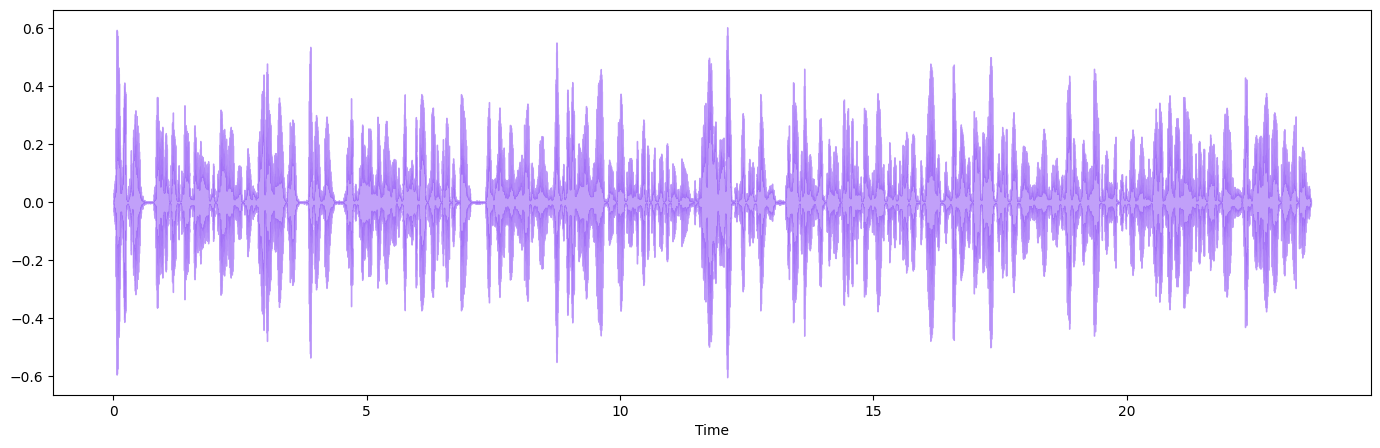

In [63]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(np.array(subject_signals_flat_list), alpha=0.5, color="#8442f5")
plt.show()

In [64]:
labels_df.unpersist()
male_labels_df.unpersist()
female_labels_df.unpersist()
train_male_labels_df.unpersist()
val_male_labels_df.unpersist()
test_male_labels_df.unpersist()
train_female_labels_df.unpersist()
val_female_labels_df.unpersist()
test_female_labels_df.unpersist()

DataFrame[value: string, filePath: string, subjectId: string]